In [1]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import keras
import os
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
import sklearn.preprocessing as sk
import random
from tensorflow.python.keras import backend as K
from sklearn.impute import SimpleImputer
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data import and preprocessing

In [2]:
GDSC_Expr = pd.read_csv("./Data New/GDSCv2.exprs.BDKANN.tsv", sep = "\t", index_col=0, decimal = ".")

CTRP_Expr = pd.read_csv("./Data New/CTRP.exprs.BDKANN.tsv", 
                    sep = "\t", index_col=0, decimal = ".")

#transpose so that input data is cell lines on rows and genes on columns 
GDSC_Expr = GDSC_Expr.T
CTRP_Expr = CTRP_Expr.T

GDSC_resp = pd.read_csv("./Data New/GDSCv2.aac.BDKANN.tsv",sep="\t")

CTRP_resp = pd.read_csv("./Data New/CTRP.aac.BDKANN.tsv",sep="\t")

GDSC_resp = GDSC_resp.T
CTRP_resp = CTRP_resp.T

# Match samples/indexes between expression and response
idx_GDSC = GDSC_Expr.index.intersection(GDSC_resp.index)
idx_CTRP = CTRP_Expr.index.intersection(CTRP_resp.index)
GDSC_Expr = GDSC_Expr.loc[idx_GDSC,:]
GDSC_resp = GDSC_resp.loc[idx_GDSC,:]
CTRP_Expr = CTRP_Expr.loc[idx_CTRP,:]
CTRP_resp = CTRP_resp.loc[idx_CTRP,:]

Mask1 = pd.read_csv("./Masks/M1New.csv", 
                    sep = ",", index_col=0, decimal = ".")

Mask2 = pd.read_csv("./Masks/M2New.csv", 
                    sep = ",", index_col=0, decimal = ".")

gene_names = pd.read_csv('./Masks/mart_export(3).txt',sep='\t')

gene_names = gene_names.drop_duplicates('NCBI gene (formerly Entrezgene) ID')

gene_dict = dict(zip(gene_names.iloc[:,1],gene_names.iloc[:,2]))

# Convert ensembl ids to entrez gene ids  and re-order to match mask 
GDSC_Expr = GDSC_Expr.loc[:,GDSC_Expr.columns.intersection(gene_names.iloc[:,1])]
GDSC_Expr = GDSC_Expr.rename(columns=gene_dict)
GDSC_Expr = GDSC_Expr.sort_index(axis=1)

CTRP_Expr = CTRP_Expr.loc[:,CTRP_Expr.columns.intersection(gene_names.iloc[:,1])]
CTRP_Expr = CTRP_Expr.rename(columns=gene_dict)
CTRP_Expr = CTRP_Expr.sort_index(axis=1)

Mask1 = Mask1.loc[CTRP_Expr.columns,:]

drugs = ['ATRA', 'Doxorubicin', 'Tamoxifen', 'Gefitinib', 'BIBW2992','masitinib', '17-AAG', 'GDC-0941', 'MK-2206', 'AZD6244', 'PLX4720']
drugIDs = ['15367', '28748', '41774', '49668', '61390', '63450', '64153', '65326', '67271','90227', '90295']
drug_dict = dict(zip(drugs,drugIDs))
GDSC_resp = GDSC_resp[GDSC_resp.columns.intersection(drugs)]
CTRP_resp = CTRP_resp[GDSC_resp.columns.intersection(drugs)]

CTRP_resp = CTRP_resp.rename(columns=drug_dict)
GDSC_resp = GDSC_resp.rename(columns=drug_dict)

imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
GDSC_resp = imputer1.fit_transform(GDSC_resp.values)

imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
CTRP_resp = imputer1.fit_transform(CTRP_resp.values)

lsP = Mask1.columns.intersection(Mask2.index)

Mask1 = Mask1.loc[:,lsP]
Mask2 = Mask2.loc[lsP,:]

Mask3 = pd.read_csv("./Masks/M3New.csv", 
                    sep = ",", index_col=0, decimal = ".")
lsD = Mask2.columns.intersection(Mask3.index)
Mask2 = Mask2.loc[:,lsD]
Mask3 = Mask3.loc[lsD,['49668', '67271', '90295', '41774']]

Mask1v2 = 1 - Mask1.values
Mask2v2 = 1 - Mask2.values
Mask3v2 = 1 - Mask3.values

In [3]:
#Custom layer for using masks
class CustomConnected(Dense):

    def __init__(self, units, Mask, **kwargs):
        #this is matrix A
        self.Mask = Mask                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  
    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.Mask)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

In [4]:
# Regularization using masks for each layer
def l1_regL1(weight_matrix):
    return 0.001 * K.sum(K.abs(weight_matrix*Mask1v2))
def l1_regL2(weight_matrix):
    return 0.001 * K.sum(K.abs(weight_matrix*Mask2v2))
def l1_regL3(weight_matrix):
    return 0.001 * K.sum(K.abs(weight_matrix*Mask3v2))

In [5]:
def create_FC_model(hidden1=1024,hidden2=512,rate1=0.01,rate2=0.01):
    """Fully connected 2 hidden-layer model with optimized parameters"""
    model = Sequential()
    model.add(Dense(hidden1, input_dim=GDSC_Expr.shape[1], kernel_initializer='random_normal', activation='relu'))
    model.add(Dropout(rate1))
    model.add(Dense(hidden2, kernel_initializer='random_normal', activation='relu'))
    model.add(Dropout(rate2))
    model.add(Dense(GDSC_resp.shape[1], kernel_initializer='random_normal', activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [6]:
def create_FC_small_model(rate1=0.01,rate2=0.01):
    """create FC model with same arch as BDKANN"""
    model = Sequential()
    model.add(Dense(Mask2.shape[0], input_dim=GDSC_Expr.shape[1], kernel_initializer='random_normal', activation='relu'))
    model.add(Dropout(rate1))
    model.add(Dense(Mask2.shape[1], kernel_initializer='random_normal', activation='relu'))
    model.add(Dropout(rate2))
    model.add(Dense(GDSC_resp.shape[1], kernel_initializer='random_normal', activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [7]:
def create_BDKANN_model():
    """create BDKANN1 (only domain knowledge)"""
    model = Sequential()
    model.add(CustomConnected(Mask2.shape[0], Mask1v2, input_dim=GDSC_Expr.shape[1], kernel_initializer='random_normal', activation='relu'))
    model.add(CustomConnected(Mask2.shape[1], Mask2v2, kernel_initializer='random_normal', activation='relu'))
    model.add(CustomConnected(GDSC_resp.shape[1], Mask3v2, kernel_initializer='random_normal', activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='Adam', metrics=['mse','mae'])
    return model

In [8]:
def create_BDKANN2_model():
    """create BDKANN2 (with regularized extra edges)"""
    model = Sequential()
    model.add(Dense(Mask2.shape[0], input_dim=GDSC_Expr.shape[1], kernel_initializer='random_normal', activation='relu', 
                    kernel_regularizer=l1_regL1))
    model.add(Dense(Mask2.shape[1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l1_regL2))
    model.add(Dense(GDSC_resp.shape[1], activation='linear', kernel_initializer='random_normal', kernel_regularizer=l1_regL3))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [9]:
def train_model(X_train, y_train, model_fn, model_file):
    model = model_fn()
    # model callbacks 
    early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, mode='auto',restore_best_weights=True)
    mc = ModelCheckpoint(filepath=model_file, monitor='val_loss', mode='auto', verbose=0, save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=16,  verbose=0, validation_split=0.2, callbacks=[early_stopping,mc])
    return model

In [13]:
X_train = GDSC_Expr
X_test = CTRP_Expr
y_train = GDSC_resp
y_test = CTRP_resp

scaler = sk.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_names = ['FCv1', 'FCv2', 'BDKANN', 'BDKANN+']
model_results = dict(zip(model_names, [pd.DataFrame(columns=Mask3.columns)]*4))
#results = pd.DataFrame(columns=model_names)
np.savetxt('./Predictions/CTRP_true_values.csv', y_test, delimiter=',')
for run in range(10):
    model_list = [create_FC_model, create_FC_small_model, create_BDKANN_model, create_BDKANN2_model]
    scores = []
    i = 0 
    for model_fn in model_list:
        model = train_model(X_train, y_train, model_fn, model_file='./Models/G-C/{}_run{}_G-C_best_model_4drug.h5'.format(model_names[i],run))

        preds = model.predict(X_test)
        np.savetxt('./Predictions/{}_run{}_G-C_4drug.csv'.format(model_names[i], run),preds,delimiter=',')
        test_score = mean_squared_error(y_test, preds, multioutput='raw_values')
        print('Run {}, {} Test RMSE =  {:.3f}'.format(run, model_names[i], np.mean(np.sqrt(test_score))))

        #scores.append(np.sqrt(test_score))
        model_results[model_names[i]] = model_results[model_names[i]].append(dict(zip(Mask3.columns,np.sqrt(test_score))),True)
        i += 1
        K.clear_session()

for name, df in model_results.items():
    df.to_csv('./Results/G-C_10runs_{}.csv'.format(name))    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              451584    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 978,436
Trainable params: 978,436
Non-trainable params: 0
_________________________________________________________________
Run 0, FCv1 Test RMSE =  0.109
Model: "sequential"
_________________________________________________________________

Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping
Run 2, FCv1 Test RMSE =  0.111
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4448)              1961568   
_________________________________________________________________
dropout (Dropout)            (None, 4448)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 867)               3857283   
_________________________________________________________________
dropout_1 (Dropout)          (None, 867)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
_______________________________________________________________

Run 4, FCv2 Test RMSE =  0.115
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_connected (CustomConn (None, 4448)              1961568   
_________________________________________________________________
custom_connected_1 (CustomCo (None, 867)               3857283   
_________________________________________________________________
custom_connected_2 (CustomCo (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run 4, BDKANN Test RMSE =  0.147
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4448)              1961568   
__________

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Run 6, BDKANN Test RMSE =  0.163
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4448)              1961568   
_________________________________________________________________
dense_1 (Dense)              (None, 867)               3857283   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
Run 6, BDKANN+ Test RMSE =  0.093
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              

Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Run 8, BDKANN+ Test RMSE =  0.094
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              451584    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 978,436
Trainable params: 978,436
Non-trainable params: 0
________________________________________________________________

In [14]:
# CV on single dataset for each model
X = CTRP_Expr.values
Y = CTRP_resp
dataset = 'CTRP'
model_list = [create_FC_model, create_FC_small_model, create_BDKANN_model, create_BDKANN2_model]
model_names = ['FCv1', 'FCv2', 'BDKANN', 'BDKANN+']
model_results_cv = dict(zip(model_names, [pd.DataFrame(columns=Mask3.columns)]*4))

i=0
for model_fn in model_list:
    fold = 1
    for train_index, test_index in KFold(10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        scaler = sk.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        model = train_model(X_train, y_train, model_fn, model_file='./Models/{}_{}_best_model_CV_4drug.h5'.format(model_names[i],dataset))

        preds = model.predict(X_test)
        np.savetxt('./Predictions/{}_fold{}_{}_CV_4drug.csv'.format(model_names[i], fold, dataset),preds,delimiter=',')
        np.savetxt('./Predictions/{}_fold{}_{}_CV_truevales.csv'.format(model_names[i], fold, dataset),y_test,delimiter=',')
        
        test_score = mean_squared_error(y_test, preds, multioutput='raw_values')
        print('Fold {}, {} Test RMSE =  {:.3f}'.format(fold, model_names[i], np.mean(np.sqrt(test_score))))
        
        model_results_cv[model_names[i]] = model_results_cv[model_names[i]].append(dict(zip(Mask3.columns,np.sqrt(test_score))),True)

        fold+=1

    i+=1
    K.clear_session()
    
for name, df in model_results_cv.items():
    df.to_csv('./Results/10foldCV_{}_{}.csv'.format(dataset,name))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              451584    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 978,436
Trainable params: 978,436
Non-trainable params: 0
_________________________________________________________________
Fold 1, FCv1 Test RMSE =  0.088
Model: "sequential_1"
______________________________________________________________

Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Fold 8, FCv1 Test RMSE =  0.090
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              451584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 2052      
Total params: 978,436
Trainable params: 978,436
Non-trainable params: 0
________________________________________________________________

Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Fold 6, FCv2 Test RMSE =  0.124
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 4448)              1961568   
_________________________________________________________________
dropout_12 (Dropout)         (None, 4448)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 867)               3857283   
_________________________________________________________________
dropout_13 (Dropout)         (None, 867)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
____________________________________________________________

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Fold 5, BDKANN Test RMSE =  0.125
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_connected_15 (CustomC (None, 4448)              1961568   
_________________________________________________________________
custom_connected_16 (CustomC (None, 867)               3857283   
_________________________________________________________________
custom_connected_17 (CustomC (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Fold 6, BDKANN Test RMSE =  0.142
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape         

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Fold 5, BDKANN+ Test RMSE =  0.067
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4448)              1961568   
_________________________________________________________________
dense_16 (Dense)             (None, 867)               3857283   
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 3472      
Total params: 5,822,323
Trainable params: 5,822,323
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Fold 6, BDKANN+ Test RMSE =  0.079
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape       

In [15]:
model_results = model_results_cv

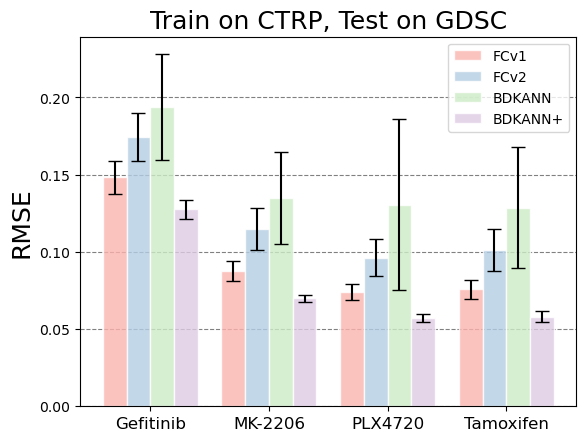

In [12]:
# set width of bar
barWidth = 0.2
drug_names = ['Gefitinib', 'MK-2206', 'PLX4720', 'Tamoxifen']

# set height of bar
bars1 = model_results['FCv1'].mean()
bars2 = model_results['FCv2'].mean()
bars3 = model_results['BDKANN'].mean()
bars4 = model_results['BDKANN+'].mean()

#set errorbars
err1 = model_results['FCv1'].std()
err2 = model_results['FCv2'].std()
err3 = model_results['BDKANN'].std()
err4 = model_results['BDKANN+'].std()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.gca().set_axisbelow(True)
plt.gca().yaxis.grid(color='gray', linestyle='dashed')

plt.bar(r1, bars1, color='#fbb4ae', yerr=err1, ecolor='black', capsize=5, align='center', alpha=0.8, width=barWidth, edgecolor='white', label='FCv1')
plt.bar(r2, bars2, color='#b3cde3', yerr=err2, ecolor='black', capsize=5, align='center', alpha=0.8, width=barWidth, edgecolor='white', label='FCv2')
plt.bar(r3, bars3, color='#ccebc5', yerr=err3, ecolor='black', capsize=5, align='center', alpha=0.8, width=barWidth, edgecolor='white', label='BDKANN')
plt.bar(r4, bars4, color='#decbe4', yerr=err4, ecolor='black', capsize=5, align='center', alpha=0.8, width=barWidth, edgecolor='white', label='BDKANN+')


plt.xticks(r1, drug_names, fontsize=12)
plt.xticks([r + 1.5*barWidth for r in range(len(bars1))], drug_names, fontsize=12)
plt.ylabel('RMSE',fontsize=18)
#plt.ylim(0,.03)
plt.title('Train on GDSC, Test on CTRP', fontsize=18)
plt.legend()
plt.savefig('./RMSE/RMSE_G-C_10runs_perdrug.png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
model_results

NameError: name 'model_results' is not defined

In [19]:
Mask3.to_csv('Masks/Mask3_trimmed.csv')

In [82]:
y_test

array([[0.07371351, 0.2534718 , 0.06002758, 0.09475599],
       [0.15963006, 0.28859982, 0.02116172, 0.06415506],
       [0.23271471, 0.18682046, 0.0298449 , 0.13534956],
       ...,
       [0.044384  , 0.12431125, 0.00587277, 0.03499755],
       [0.        , 0.28404519, 0.00617875, 0.008278  ],
       [0.26304793, 0.20439527, 0.02890162, 0.06415506]])

In [89]:
max(GDSC_resp[:,3])

0.262516037759077